### Performance Evaluation ###

In [1]:
import sys
import os
import numpy as np
import json
import pandas as pd
import logging
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

logger = logging.getLogger(__name__)

# PyTorch
import torch
from torchvision import ops

# Hugging Face Library
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

%load_ext autoreload
%autoreload 2
import computervision
from computervision.imageproc import is_image, ImageData, clipxywh, xyxy2xywh, xywh2xyxy
from computervision.datasets import DETRdataset, get_gpu_info
from computervision.transformations import AugmentationTransform
from computervision.performance import DetectionMetrics

print(f'Project version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

Project version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
# Check GPU availability
device, device_str = get_gpu_info()
print(f'Current device {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.8.0a0+34c6371d24.nv25.08
CUDA version:      13.0
CUDNN version:     91200
Device for model training/inference: cuda:0
Current device cuda:0


In [3]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey', offset_xy=(0, 0)):
    offset_xy = (10 + offset_xy[0], 100 + offset_xy[1])
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

def detr_detect(detr_model, detr_processor, image, threshold):
    """ Predicts bounding boxes in xywh format """
    assert len(im.shape) == 3, 'Need RGB image as input'
    x_lim, y_lim = (0, image.shape[1]), (0, image.shape[0])
    im_input = processor(im, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**im_input)
    output = processor.post_process_object_detection(model_output, 
                                                     target_sizes=torch.tensor([image.shape[:2]]),
                                                     threshold=threshold)
    output_boxes = output[0].get('boxes').cpu().numpy()
    if len(output_boxes) > 0:
        bboxes = [clipxywh(xyxy2xywh(list(box)), xlim=x_lim, ylim=y_lim, decimals=0) for box in output_boxes]
        areas = [int(box[2]*box[3]) for box in bboxes]
        categories = list(output[0].get('labels').cpu().numpy())
        scores = output[0].get('scores').cpu().numpy()
        categories = [int(c) for c in categories]
        scores = [np.around(s, decimals=4) for s in scores]
        predictions = {'bboxes': bboxes, 'areas': areas, 'categories': categories, 'scores': scores}
    else:
        logger.warning(f'No predictions for threshold {threshold}.')
        predictions = None
    return predictions

### Test data ###

In [4]:
# HSDM DATA
image_dir = os.path.join(os.environ.get('DATA'), 'dataset_object_240921')
df_file_name = 'objectdata_240921_clean_ide.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)
display(df.head(2))

file_col = 'multi_file'
pos_col = 'pos'
bbox_col = 'bbox'

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)

,multi_file,pos,box_score,bbox,PatientIDE,annotator_name,d1,d2,d3,d4,d5,d6,disease,quality,single_file
0,457fecca_20180208_00.png,20,0.565375,"[0.0, 453.28, 267.08, 865.22]",457fecca,Maria,2,2,2,3,2,0,stable,yes,box_457fecca_20180208_00_00.png
1,8fb6f1a1_20220322_00.png,3,0.989590,"[0.0, 69.95, 501.94, 892.3]",8fb6f1a1,Maria,3,2,3,3,2,3,healthy,yes,box_8fb6f1a1_20220322_00_02.png


In [5]:
# Dentex testing data
image_dir = os.path.join(os.environ.get('DATA'), 'dentex_detection_250928', 'test')
df_file_name = 'train_quadrant_enumeration_test_set.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)
df = df.loc[(df['dset'] == 'test') & (df['transformation'] == 2)]
display(df.head(2))

file_col = 'file_name'
pos_col = 'ada'
bbox_col = 'bbox'

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)

,bbox,quadrant,ada,file_name,file_base_name,quadrants,height,width,transformation,transformation_name,dset
11230,"[589, 0, 45, 306]",1.0,8.0,test_train_219_01_02.png,train_219,1,635,306,2,test_set,test
11231,"[527, 0, 91, 306]",1.0,7.0,test_train_219_01_02.png,train_219,1,635,306,2,test_set,test


In [147]:
# Roboflow test data
image_dir = os.path.join(os.environ.get('DATA'), 'dataset_object_roboflow_240930')
df_file_name = 'roboflow_240930.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)
display(df.head(2))
# What are the categories in this data set
print(list(df['category'].unique()))

file_col = 'multi_file'
pos_col = 'pos'
bbox_col = 'bbox'

# Let's get rid of the rows that do not have locations
df = df.loc[~df[pos_col].isnull()]

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)
print(f'Using {len(checked)} images from the Roboflow data set')
print(f'Annotations: {df.shape[0]}')

,id,license,file_name,height,width,date_captured,file_name_hash,dset,multi_file,bbox,category,disease,pos,box_id
0,0,1,pbws-super-set-1-completed__PBWs_Super_Set_2-0...,480,640,2024-09-17T23:44:33+00:00,40762886f4,train,40762886f4.jpg,"[381.0, 242.0, 481.474, 279.948]",composite,composite,NaN,40762886f4_0
1,0,1,pbws-super-set-1-completed__PBWs_Super_Set_2-0...,480,640,2024-09-17T23:44:33+00:00,40762886f4,train,40762886f4.jpg,"[8.0, 0.0, 130.293, 176.736]",tooth 23,teeth,11.0,40762886f4_1


['composite', 'tooth 23', 'tooth 25', 'tooth 26', 'tooth 27', 'tooth 33', 'tooth 34', 'tooth 35', 'tooth 36', 'tooth 37', 'tooth 17', 'tooth 16', 'tooth 15', 'tooth 46', 'tooth 47', 'caries', 'tooth 24', 'Calculus', 'root filling', 'crown', 'tooth 45', 'tooth 44', 'tooth 14', 'tooth 18', 'tooth 48', 'tooth 13', 'tooth 43', 'tooth 28', 'tooth 38', 'tooth 12', 'amalgam', 'implant', 'tooth 22', 'periapical pathology', 'tooth 32']
Using 991 images from the Roboflow data set
Annotations: 8788


### Model and image processor ###

In [6]:
model_name = 'rtdetr_251001_02'
model_dir = os.path.join(os.environ.get('DATA'), 'model', model_name)
model_json_name = f'{model_name}.json'
model_json_file = os.path.join(model_dir, model_json_name)

checkpoint_name = 'checkpoint-17500'
checkpoint = os.path.join(model_dir, checkpoint_name)

# Load model parameters
with open(model_json_file, mode='r') as fl:
    model_parameters = json.load(fl)
display(model_parameters.keys())

# Category ID to label conversion
id2label = model_parameters.get('id2label')
id2label = {int(k): int(v) for k,v in id2label.items()}

# Load the image processor
processor = RTDetrImageProcessor.from_pretrained(checkpoint)
# Load the model
model = RTDetrV2ForObjectDetection.from_pretrained(checkpoint).to(device)

dict_keys(['model_info', 'id2label', 'training_args', 'processor_params', 'bbox_format'])

In [7]:
display(model_parameters.get('model_info'))

{'model_version': 2,
 'device_number': 2,
 'project_version': 'v0.0.1',
 'model_name': 'rtdetr_251001_02',
 'train_image_dir': '/app/data_model/dentex_detection_250928',
 'val_image_dir': '/app/data_model/dentex_detection_250928/test',
 'model_dir': '/app/data_model/model',
 'im_width': 640,
 'im_height': 640,
 'hf_checkpoint': 'PekingU/rtdetr_v2_r101vd',
 'training_checkpoint': 'PekingU/rtdetr_v2_r101vd',
 'train_quadrants': [14, 23],
 'val_quadrants': [14, 23],
 'train_transform_name': 'train_14_23',
 'val_transform_name': 'val'}

### Predict on an image ###

True: [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
Pred: [22, 18, 21, 23, 20]


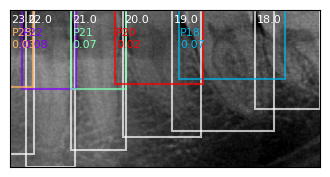

In [9]:
figsize = (4, 4)
threshold = 0.02
idx = 74
file_name = file_name_list[idx]
    
file = os.path.join(image_dir, file_name)
im = ImageData().load_image(file)
im = ImageData().np2color(im)
df_file = df.loc[df[file_col] == file_name]
bbox_list = df_file[bbox_col].tolist()
pos_list = df_file[pos_col].tolist()
im_width, im_height = im.shape[1], im.shape[0]
x_lim, y_lim = (0, im_width), (0, im_height)
    
# Predict positions
output = detr_detect(detr_model=model, detr_processor=processor, image=im, threshold=threshold)
if output is not None:
    output_bbox_list = output.get('bboxes')
    output_cat_list = output.get('categories')
    output_pos_list = [id2label.get(cat) for cat in output_cat_list]
    score_list = output.get('scores')
    output_label_list = [f'P{p}\n{s:.2f}' for p, s in zip(output_pos_list, score_list)]

    print(f'True: {pos_list}')
    print(f'Pred: {output_pos_list}')
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_boxes(image=im, box_list=bbox_list, label_list=pos_list, color='w', ax=ax)
    ax = plot_boxes(image=im, box_list=output_bbox_list, label_list=output_label_list, ax=ax, offset_xy=(0, 200))
    plt.show()

[197, 0, 135, 222]
20
[182, 0, 153, 129]


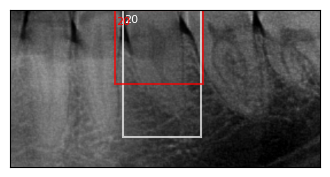

IoU for label 20: 0.5392976403236389


In [10]:
# Let's pick one ground truth and one predicted position
# So we can calculate the iou
true_pos = 20
true_bbx = list(bbox_list[pos_list.index(true_pos)])
true_bbx = clipxywh(true_bbx, xlim=x_lim, ylim=y_lim, decimals=0)
print(true_bbx)

pred_pos_idx = output_pos_list.index(true_pos)
pred_pos = output_pos_list[pred_pos_idx]
print(pred_pos)
pred_bbx = output_bbox_list[pred_pos_idx]
print(pred_bbx)

# Plot this situation
fig, ax = plt.subplots(figsize=figsize)
ax = plot_boxes(image=im, box_list=[true_bbx], label_list=[true_pos], ax=ax, color='w')
ax = plot_boxes(image=im, box_list=[pred_bbx], label_list=[pred_pos], ax=ax, color='r', offset_xy=(0, 20))
plt.show()

# Calculate the IoU for the predicted bounding box and the ground truth
iou = DetectionMetrics.compute_iou(bbox_1=true_bbx, bbox_2=pred_bbx, bbox_format='xywh', method='pt')
print(f'IoU for label {true_pos}: {iou}')

### Classify predictions ###
In object detection, AP (Average Precision) scores are calculated based on the area under a precision-recall curve and are used to evaluate model performance. The overall model performance across all object classes is summarized by the mAP (mean Average Precision). [1, 2, 3, 4]  
Here is a step-by-step breakdown of how to calculate AP scores for object detection: [5, 6]  
1. Calculate Intersection over Union (IoU) IoU measures the overlap between a predicted bounding box and its corresponding ground truth bounding box. The score is used to determine whether a detection is correct or not. [7, 8, 9, 10]  
The formula for IoU is: 

• Intersection: The area of overlap between the predicted and ground truth boxes. 
• Union: The total area covered by both bounding boxes combined. [9, 11, 12, 13]  

2. Determine True Positives, False Positives, and False Negatives Using a pre-defined IoU threshold (e.g., 0.5), classify each prediction as a True Positive (TP), False Positive (FP), or False Negative (FN). 

• True Positive (TP): A correct detection. This happens when a predicted bounding box has an IoU greater than or equal to the threshold and the correct class label. 
• False Positive (FP): An incorrect detection. This can be a predicted box with an IoU below the threshold, or a duplicate detection of an object already counted as a TP. 
• False Negative (FN): A missed ground truth object. This occurs when the model fails to detect an object that is present in the image. 
• Note: True Negatives (correctly identifying the background) are not used in AP calculation. [6, 14, 15, 16, 17]  

3. Calculate precision and recall Precision and recall are calculated at each unique confidence score output by the model across the entire dataset. To do this, predictions are sorted in descending order based on their confidence score. 

• Precision: The ratio of true positive predictions to the total number of positive predictions. A high precision score means the model is accurate when it does predict an object. 
• Recall: The ratio of true positive predictions to the total number of actual positive objects. A high recall score means the model successfully finds most of the relevant objects. [18, 19, 20]  

4. Create the precision-recall curve Plot the calculated precision and recall values for each class, with recall on the x-axis and precision on the y-axis. The shape of the curve reveals the trade-off between precision and recall at different confidence thresholds. A good model will maintain high precision as recall increases. [21, 22, 23, 24, 25]  
5. Calculate Average Precision (AP) The Average Precision (AP) for a single class is the area under its precision-recall curve. This provides a single-value summary of performance for that class. [3, 6, 21]  
Historically, different methods have been used to compute this area: 

• 11-Point Interpolation (PASCAL VOC 2008): Averages the precision values at 11 specific recall levels (0.0, 0.1, ..., 1.0). 
• All-Point Interpolation (PASCAL VOC 2010+ and modern methods): Integrates the area under all points of the precision-recall curve for a more accurate calculation. [23, 26, 27, 28, 29]  

6. Calculate mean Average Precision (mAP) mAP is the final evaluation metric and is simply the average of the AP scores across all object classes in the dataset. This gives an overall performance score for the model. [1, 3, 21, 30, 31]  
Some benchmarks, like the Common Objects in Context (COCO) challenge, use a more complex mAP calculation that averages AP scores across multiple IoU thresholds (from 0.5 to 0.95) and all object classes. [2]  

AI responses may include mistakes.

[1] https://www.lightly.ai/blog/mean-average-precision
[2] https://www.v7labs.com/blog/mean-average-precision
[3] https://www.lightly.ai/blog/mean-average-precision
[4] https://docs.ultralytics.com/guides/yolo-performance-metrics/
[5] https://www.digitalocean.com/community/tutorials/mean-average-precision
[6] https://medium.com/data-science/what-is-average-precision-in-object-detection-localization-algorithms-and-how-to-calculate-it-3f330efe697b
[7] https://www.ultralytics.com/glossary/intersection-over-union-iou
[8] https://www.lightly.ai/blog/intersection-over-union
[9] https://xailient.com/blog/what-is-mean-average-precision-and-how-does-it-work/
[10] https://www.oreilly.com/library/view/hands-on-convolutional-neural/9781789130331/a0267a8a-bd4a-452a-9e5a-8b276d7787a0.xhtml
[11] https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/
[12] https://www.v7labs.com/blog/yolo-object-detection
[13] https://www.einfochips.com/blog/understanding-object-localization-with-deep-learning/
[14] https://bioresources.cnr.ncsu.edu/resources/a-fast-and-robust-artificial-intelligence-technique-for-wood-knot-detection/
[15] https://www.nature.com/articles/s41598-025-86323-1
[16] https://www.fuzzylabs.ai/blog-post/mlops-pipeline-on-the-edge
[17] https://www.cell.com/heliyon/fulltext/S2405-8440(25)01761-X
[18] https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
[19] https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/how-compute-accuracy-for-object-detection-works.htm
[20] https://www.linkedin.com/pulse/choosing-right-metrics-recall-precision-pr-curve-roc-juan-carlos-cfeef
[21] https://www.lightly.ai/blog/mean-average-precision
[22] https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248
[23] https://github.com/rafaelpadilla/Object-Detection-Metrics
[24] https://arxiv.org/html/2307.02694v3
[25] https://www.researchgate.net/publication/387286580_Machine_Learning-Based_Network_Intrusion_Detection_for_IOT_and_Smart_Detection_Using_Recursive_Feature_Elimination_Binning_Technique_and_Grid_Search_CV
[26] https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
[27] https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
[28] https://www.superannotate.com/blog/mean-average-precision-and-its-uses-in-object-detection
[29] http://vision.uamt.feec.vutbr.cz/ROZ/lectures/MachineLearning_mAP.pdf
[30] https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
[31] https://arxiv.org/html/2302.10473v4



True labels:        [18, 19, 20, 21, 22, 23]
Pred labels:        [22, 18, 21, 23, 20]
Missed predictions: [19]
Prediction for label 1/5: 22: FP with IoU: 0.47843262553215027


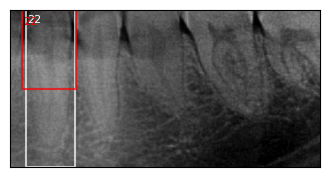

Prediction for label 2/5: 18: FP with IoU: 0.17453403770923615


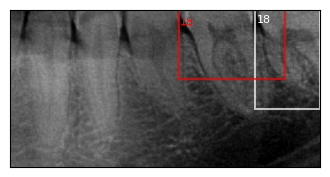

Prediction for label 3/5: 21: TP with IoU: 0.5556870102882385


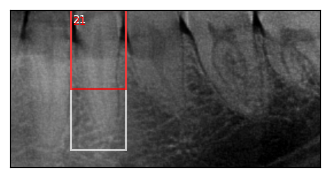

Prediction for label 4/5: 23: TP with IoU: 0.5116121172904968


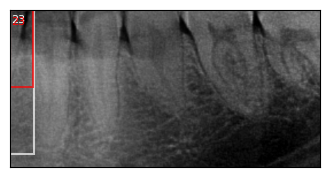

Prediction for label 5/5: 20: TP with IoU: 0.5392976403236389


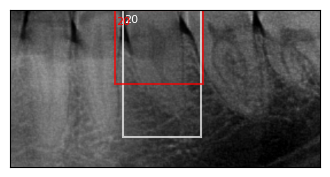

[22, 18, 21, 23, 20]
[18, 19, 20, 21, 22, 23]
[0.47843262553215027, 0.17453403770923615, 0.5556870102882385, 0.5116121172904968, 0.5392976403236389]
['FP', 'FP', 'TP', 'TP', 'TP']


,pred_label,TP,score,IoU,duplicate_TP
0,22,FP,0.0839,0.478433,False
1,18,FP,0.0685,0.174534,False
2,21,TP,0.0662,0.555687,False
3,23,TP,0.0256,0.511612,False
4,20,TP,0.0240,0.539298,False


In [11]:
# Performance evaluations
score_threshold = 0.02
iou_threshold = 0.5

# Ground truth
true_labels = [int(l) for l in df_file[pos_col].tolist()]
true_bboxes = df_file[bbox_col].tolist()
true_bboxes = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in true_bboxes]
print(f'True labels:        {true_labels}')

# Predictions
output = detr_detect(detr_model=model, detr_processor=processor, image=im, threshold=score_threshold)
pred_labels = [int(id2label.get(cat)) for cat in output.get('categories')]
pred_bboxes = output.get('bboxes')
pred_bboxes = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in pred_bboxes]
pred_scores = output.get('scores')
print(f'Pred labels:        {pred_labels}')

# Determine the false negative samples
# Predictions that were missed by the object detection
missed = sorted(list(set(true_labels).difference(pred_labels)))
print(f'Missed predictions: {missed}')

# We want to classify the predictions
iou_list = []
prediction_list = []
for p, p_label in enumerate(pred_labels):
    
    p_bbox = pred_bboxes[p]
    
    # When there is no label for this prediction, it is a FP prediction
    # NOTE: the FP numbers will be too high if not all of the instances are labeled!
    p_prediction = 'FP'
    p_iou = np.nan
    
    # Let's check each ground truth labels if we have a match
    pt_iou_list = []
    t_bbx_list = []
    
    for t, t_label in enumerate(true_labels):
        if p_label == t_label:
            t_bbox = true_bboxes[t]
            pt_iou = DetectionMetrics.compute_iou(p_bbox, t_bbox, bbox_format='xywh', method='pt')
            pt_iou_list.append(pt_iou)
            t_bbx_list.append(t_bbox)
            
    if len(pt_iou_list) > 0:
        p_iou = np.max(pt_iou_list)
        t_bbx = t_bbx_list[np.argmax(pt_iou_list)]
        if p_iou >= iou_threshold:
            p_prediction = 'TP'
        
        print(f'Prediction for label {p + 1}/{len(pred_labels)}: {p_label}: {p_prediction} with IoU: {p_iou}')
        
        # Plot the situation when we have a match
        fig, ax = plt.subplots(figsize=figsize)
        ax = plot_boxes(image=im, box_list=[t_bbx], label_list=[p_label], ax=ax, color='w')
        ax = plot_boxes(image=im, box_list=[p_bbox], label_list=[p_label], ax=ax, color='r', offset_xy=(0, 20))
        plt.show()

    iou_list.append(p_iou)
    prediction_list.append(p_prediction)

# What if we predict the same class twice and both are TP?
# We count only the first one as a TP, the others we set to FP.
c = pd.DataFrame({'pred_label': pred_labels,
                  'TP': prediction_list,
                  'score': pred_scores,
                  'IoU': iou_list})

c = c.assign(duplicate_TP=False)

# Flip duplicate TP predictions
d = c.copy()
d.loc[(c.duplicated(subset=['pred_label', 'TP'])) & (c['TP'] == 'TP'), 'TP'] = 'FP'
d.loc[(c.duplicated(subset=['pred_label', 'TP'])) & (c['TP'] == 'TP'), 'duplicate_TP'] = True

print(pred_labels)
print(true_labels)
print(iou_list)
print(prediction_list)
display(d)

### Prediction classification method ###

In [173]:
def classify_predictions(true_labels, true_bboxes, pred_labels, pred_bboxes, iou_threshold):

    # Make sure that the true and pred labels have the same type
    assert all([isinstance(true_labels, list), isinstance(pred_labels, list)])
    assert all([isinstance(true_bboxes, list), isinstance(pred_bboxes, list)])
    
    # Missed predictions (FN)
    missed = sorted(list(set(true_labels).difference(pred_labels)))
    # Classify predictions (TP:1, FP:0)
    iou_list = []
    prediction_list = []
    for p, p_label in enumerate(pred_labels):
        p_bbox = pred_bboxes[p]
        p_prediction = 0 # FP
        p_iou = np.nan
        pt_iou_list = []
        for t, t_label in enumerate(true_labels):
            if p_label == t_label:
                t_bbox = true_bboxes[t]
                pt_iou = DetectionMetrics.compute_iou(p_bbox, t_bbox, bbox_format='xywh', method='pt')
                pt_iou_list.append(pt_iou)
        if len(pt_iou_list) > 0:
            p_iou = np.max(pt_iou_list)
            if p_iou >= iou_threshold:
                p_prediction = 1 # TP
        prediction_list.append(p_prediction)
        iou_list.append(p_iou)
    
    pred_df = pd.DataFrame({'pred_label': pred_labels,
                            'TP': prediction_list,
                            'IoU': iou_list})
    
    pred_df = pred_df.assign(FN=len(missed),
                             duplicate_TP=False)
    
    output_df = pred_df.copy()
    # Flipt duplicate TP predictions for the same label with FP
    output_df.loc[(pred_df.duplicated(subset=['pred_label', 'TP'])) & (pred_df['TP'] == 1), 'TP'] = 0
    output_df.loc[(pred_df.duplicated(subset=['pred_label', 'TP'])) & (pred_df['TP'] == 1), 'duplicate_TP'] = True

    return missed, output_df

In [174]:
# Input
true_labels = df_file[pos_col].tolist()
true_labels = [int(l) for l in true_labels]
true_bboxes = df_file[bbox_col].tolist()
true_bboxes = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in true_bboxes]

pred_labels = [int(id2label.get(cat)) for cat in output.get('categories')]
pred_bboxes = output.get('bboxes')
pred_bboxes = [clipxywh(list(box), xlim=x_lim, ylim=y_lim, decimals=0) for box in pred_bboxes]
scores = output.get('scores')

print(f'True labels: {true_labels}')
print(f'Pred labels: {pred_labels}')

missed, predictions_df = DetectionMetrics.\
    classify_predictions(true_labels=true_labels, 
                         true_bboxes=true_bboxes, 
                         pred_labels=pred_labels, 
                         pred_bboxes=pred_bboxes, 
                         iou_threshold=iou_threshold)

print(missed)
display(predictions_df)

True labels: [28, 29, 30, 31, 6, 5, 4, 3]
Pred labels: [29, 30, 3]
[4, 5, 6, 28, 31]


,pred_label,TP,IoU,FN,duplicate_TP
0,29,0,0.269898,5,False
1,30,0,0.194214,5,False
2,3,0,0.223632,5,False
